# Notebook for Topic 5 - Time Series anomaly detection

<hr style="border-top: 1px solid #001a79;" />

## Introduction

This Notebook is a recreation of the 'Timeseries anomaly detection using an Autoencoder' blogpost available at https://keras.io/examples/timeseries/timeseries_anomaly_detection/

In this notebook, I will demonstrate the use of Keras and TensorFlow to build and train a model for timeseries anomaly detection using the NAB (Numenta Anomaly Benchmark) dataset. The NAB dataset is a collection of labeled timeseries data files that are commonly used to evaluate the performance of anomaly detection algorithms. I will use Keras and TensorFlow to build and train a deep learning model that can detect anomalies in the NAB timeseries data. I will start by setting up the environment and loading the necessary libraries, then I will explore the NAB dataset and preprocess the data for use with the model. Next, I will build and train the model, and finally I will evaluate its performance on the NAB dataset.

In [1]:
# Import the necessary modules


from pprint import pprint

# library for numerical computing
import numpy as np

# library for data manipulation and analysis
import pandas as pd

# package for building and training deep learning models in TensorFlow.
from tensorflow import keras
from tensorflow.keras import layers

# library for data visualization
from matplotlib import pyplot as plt

## Download the data

In this example, data from the NAB Data Corpus will be used: https://github.com/numenta/NAB/tree/master/data

The NAB corpus is a collection of 58 timeseries data files that are intended for use in research on streaming anomaly detection. The data includes both real-world and artificial timeseries data, and contains labeled anomalous periods of behavior. The data is composed of ordered, timestamped, single-valued metrics.

In [2]:
# URL for the Github NAB data repository
master_url_root = "https://raw.githubusercontent.com/numenta/NAB/master/data/"

# Parse a URL for dataset without anomaly
df_small_noise_url_suffix = "artificialNoAnomaly/art_daily_small_noise.csv"
df_small_noise_url = master_url_root + df_small_noise_url_suffix

# Parse a URL for dataset with anomaly
df_daily_jumpsup_url_suffix = "artificialWithAnomaly/art_daily_jumpsup.csv"
df_daily_jumpsup_url = master_url_root + df_daily_jumpsup_url_suffix



# Download dataset without anomaly
df_small_noise = pd.read_csv(
    df_small_noise_url, parse_dates=True, index_col="timestamp"
)

# Download dataset with anomaly
df_daily_jumpsup = pd.read_csv(
    df_daily_jumpsup_url, parse_dates=True, index_col="timestamp"
)

#### Print the 5 first rows of data

In [3]:
print("First 5 rows of data without Anomalies:")
df_small_noise.head()

First 5 rows of data without Anomalies:


,value
timestamp,
2014-04-01 00:00:00,18.324919
2014-04-01 00:05:00,21.970327
2014-04-01 00:10:00,18.624806
2014-04-01 00:15:00,21.953684
2014-04-01 00:20:00,21.909120


In [4]:
print("First 5 rows of data with Anomalies:")
df_daily_jumpsup.head()

First 5 rows of data with Anomalies:


,value
timestamp,
2014-04-01 00:00:00,19.761252
2014-04-01 00:05:00,20.500833
2014-04-01 00:10:00,19.961641
2014-04-01 00:15:00,21.490266
2014-04-01 00:20:00,20.187739


## Visualise the data

#### Data without anomalies

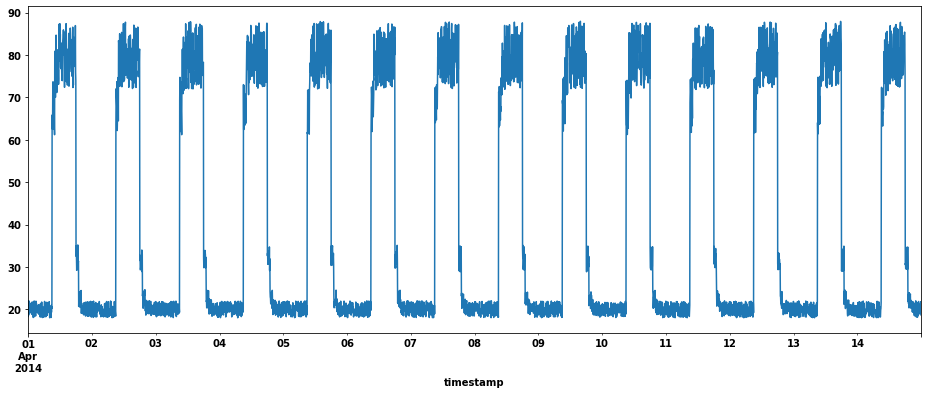

In [5]:
fig, ax = plt.subplots(figsize=(16,6))
df_small_noise.plot(legend=False, ax=ax)
plt.show()

#### Data with anomalies

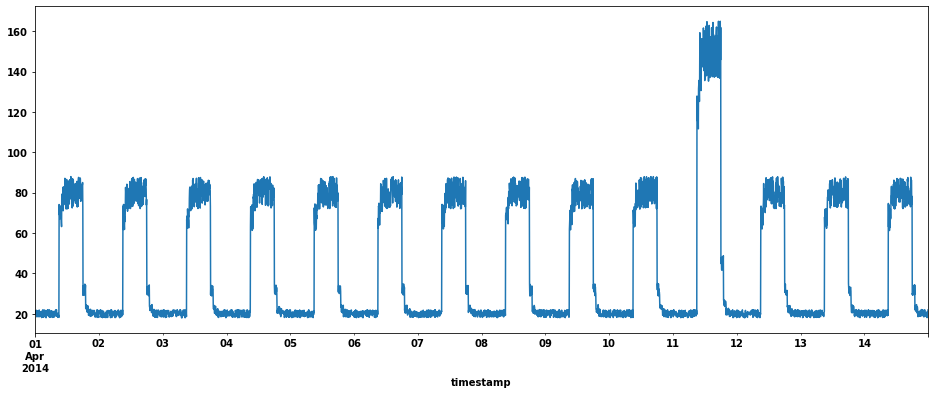

In [6]:
fig, ax = plt.subplots(figsize=(16,6))
df_daily_jumpsup.plot(legend=False, ax=ax)
plt.show()

## Prepare the training data

#### Normalize the data

Normalization is a common preprocessing step in machine learning that involves transforming the data so that it has zero mean and unit variance. This can be useful for algorithms that are sensitive to the scale of the input data, as it helps to ensure that all features are on a similar scale

In [7]:
# Calculate and save the values of the mean and standard deviation of the no anomalies dataset
training_mean = df_small_noise.mean()
training_std = df_small_noise.std()

# Displaye the values
print('Mean value of no anomalies dataset: {:.3f}'.format(training_mean.value))
print('Standard Deviation of no anomalies dataset: {:.3f}'.format(training_std.value))

# Normalize the no anomalies dataset
df_training_value = (df_small_noise - training_mean) / training_std
print("\nNumber of training samples:", len(df_training_value))

Mean value of no anomalies dataset: 42.438
Standard Deviation of no anomalies dataset: 28.077

Number of training samples: 4032


#### Visualise the normalized no anomalies dataset

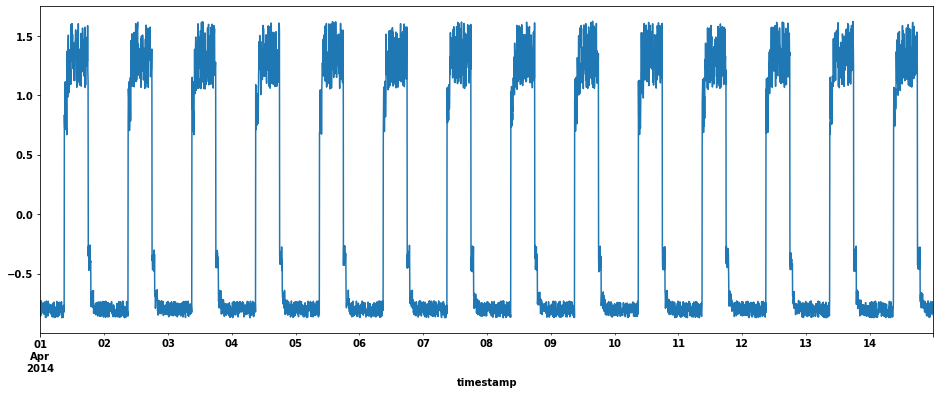

In [8]:
fig, ax = plt.subplots(figsize=(16,6))
df_training_value.plot(legend=False, ax=ax)
plt.show()

#### Create sequences

The function below will be used to create a set of input sequences for training a ML model. This function will create overlapping sequences of the input values, with each sequence shifted by 1 value comparing to the previous one. This allows the model to learn dependencies between the values at different time steps.

In [9]:
TIME_STEPS = 288

# Generated training sequences for use in the model.
def create_sequences(values, time_steps=TIME_STEPS, verbose=False):
    if verbose:
        print("Input Array:")
        print(values)
        print("\nSliding Windows:")        
        
    output = []
    for i in range(len(values) - time_steps + 1):
        app_values = values[i : (i + time_steps)]
        if verbose:
            print("Window nr {}: {}".format(i+1, app_values))
        output.append(app_values)
        
    if verbose:
        print("\nFinal Array:")
        pprint(output)
        
    return np.stack(output)

In [10]:
# Example of 'create_sequences' usage:
create_sequences([1,2,3,4,5,6,7,8,9,10], time_steps=4, verbose=True);

Input Array:
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

Sliding Windows:
Window nr 1: [1, 2, 3, 4]
Window nr 2: [2, 3, 4, 5]
Window nr 3: [3, 4, 5, 6]
Window nr 4: [4, 5, 6, 7]
Window nr 5: [5, 6, 7, 8]
Window nr 6: [6, 7, 8, 9]
Window nr 7: [7, 8, 9, 10]

Final Array:
[[1, 2, 3, 4],
 [2, 3, 4, 5],
 [3, 4, 5, 6],
 [4, 5, 6, 7],
 [5, 6, 7, 8],
 [6, 7, 8, 9],
 [7, 8, 9, 10]]


In [11]:
# The alternative below should be more efficient than the original implementation of 'create_sequences',
# as it avoids the overhead of creating and appending to a Python list and use more efficient NumPy array slicing instead.

def create_sequences(values, time_steps=TIME_STEPS):
    values = np.asarray(values)
    return np.stack([values[i : (i + time_steps)] for i in range(len(values) - time_steps + 1)])

In [12]:
# Use normalised no anomalies dataset

x_train = create_sequences(df_training_value.values)
print("Training input shape: ", x_train.shape)

Training input shape:  (3745, 288, 1)


## Build a Model

In [13]:
nn_layers = [
    layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
    layers.Conv1D(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),    
    layers.Dropout(rate=0.2),
    layers.Conv1D(
        filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
    ),
    layers.Conv1DTranspose(
        filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
    ),
    layers.Dropout(rate=0.2),
    layers.Conv1DTranspose(
        filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
    ),
    layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),    
]

In [14]:
# define a Sequential Model
model = keras.Sequential(nn_layers)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 144, 32)           256       
                                                                 
 dropout (Dropout)           (None, 144, 32)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 72, 16)            3600      
                                                                 
 conv1d_transpose (Conv1DTra  (None, 144, 16)          1808      
 nspose)                                                         
                                                                 
 dropout_1 (Dropout)         (None, 144, 16)           0         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 288, 32)          3616      
 ranspose)                                              

## Train the Model

In [15]:
history = model.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

Epoch 1/50
27/27 [==============================] - 3s 58ms/step - loss: 0.5164 - val_loss: 0.0753
Epoch 2/50
27/27 [==============================] - 1s 37ms/step - loss: 0.0794 - val_loss: 0.0460
Epoch 3/50
27/27 [==============================] - 1s 34ms/step - loss: 0.0594 - val_loss: 0.0385
Epoch 4/50
27/27 [==============================] - 1s 31ms/step - loss: 0.0499 - val_loss: 0.0323
Epoch 5/50
27/27 [==============================] - 1s 33ms/step - loss: 0.0429 - val_loss: 0.0290
Epoch 6/50
27/27 [==============================] - 1s 34ms/step - loss: 0.0382 - val_loss: 0.0269
Epoch 7/50
27/27 [==============================] - 1s 33ms/step - loss: 0.0345 - val_loss: 0.0267
Epoch 8/50
27/27 [==============================] - 1s 33ms/step - loss: 0.0317 - val_loss: 0.0259
Epoch 9/50
27/27 [==============================] - 1s 34ms/step - loss: 0.0296 - val_loss: 0.0243
Epoch 10/50
27/27 [==============================] - 1s 35ms/step - loss: 0.0276 - val_loss: 0.0240
Epoch 11/

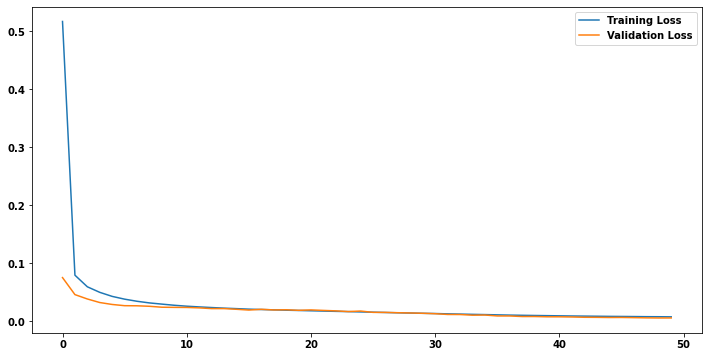

In [16]:
fig, ax = plt.subplots(figsize=(12,6))

plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

## Detecting anomalies

118/118 [==============================] - 1s 6ms/step


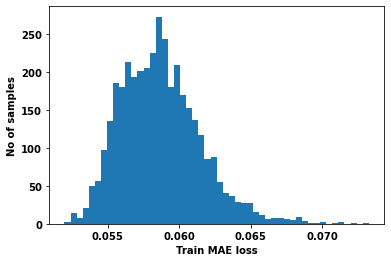

Reconstruction error threshold:  0.07327551235646737


In [17]:
# Get train MAE loss.
x_train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

#### Compare recontruction

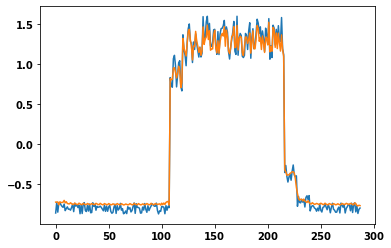

In [18]:
# Checking how the first sequence is learnt
plt.plot(x_train[0])
plt.plot(x_train_pred[0])
plt.show()

#### Prepare test data

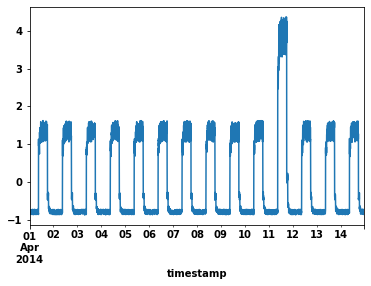

Test input shape:  (3745, 288, 1)
118/118 [==============================] - 1s 4ms/step


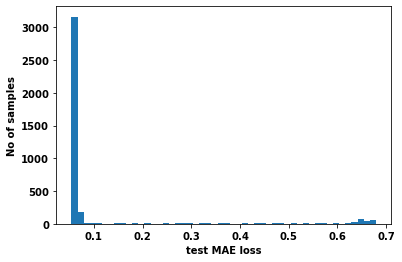

Number of anomaly samples:  401
Indices of anomaly samples:  (array([2698, 2699, 2701, 2702, 2703, 2704, 2705, 2706, 2707, 2708, 2709,
       2710, 2711, 2712, 2713, 2714, 2715, 2716, 2717, 2718, 2719, 2720,
       2721, 2722, 2723, 2724, 2725, 2726, 2727, 2728, 2729, 2730, 2731,
       2732, 2733, 2734, 2735, 2736, 2737, 2738, 2739, 2740, 2741, 2742,
       2743, 2744, 2745, 2746, 2747, 2748, 2749, 2750, 2751, 2752, 2753,
       2754, 2755, 2756, 2757, 2758, 2759, 2760, 2761, 2762, 2763, 2764,
       2765, 2766, 2767, 2768, 2769, 2770, 2771, 2772, 2773, 2774, 2775,
       2776, 2777, 2778, 2779, 2780, 2781, 2782, 2783, 2784, 2785, 2786,
       2787, 2788, 2789, 2790, 2791, 2792, 2793, 2794, 2795, 2796, 2797,
       2798, 2799, 2800, 2801, 2802, 2803, 2804, 2805, 2806, 2807, 2808,
       2809, 2810, 2811, 2812, 2813, 2814, 2815, 2816, 2817, 2818, 2819,
       2820, 2821, 2822, 2823, 2824, 2825, 2826, 2827, 2828, 2829, 2830,
       2831, 2832, 2833, 2834, 2835, 2836, 2837, 2838, 2839, 2

In [19]:
df_test_value = (df_daily_jumpsup - training_mean) / training_std
fig, ax = plt.subplots()
df_test_value.plot(legend=False, ax=ax)
plt.show()

# Create sequences from test values.
x_test = create_sequences(df_test_value.values)
print("Test input shape: ", x_test.shape)

# Get test MAE loss.
x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

## Plot anomalies

In [20]:
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
anomalous_data_indices = []
for data_idx in range(TIME_STEPS - 1, len(df_test_value) - TIME_STEPS + 1):
    if np.all(anomalies[data_idx - TIME_STEPS + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)

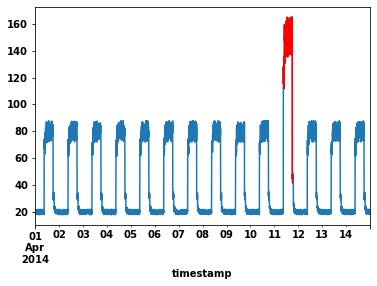

In [21]:
df_subset = df_daily_jumpsup.iloc[anomalous_data_indices]
fig, ax = plt.subplots()
df_daily_jumpsup.plot(legend=False, ax=ax)
df_subset.plot(legend=False, ax=ax, color="r")
plt.show()